In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

In [2]:
# размеры шрифтов на графиках matplotlib

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
fracs_count = 4 # количество трещин
K_c = 1e6 # Па*м^(1/2) трещиностойкость породы

In [4]:
# параметры задачи в символьном виде

# суммарный расход на забое и забойное давление
Q_0, p_0 = symbols('Q0 p0', real=True)

# расходы на каждой из трещин
Q = np.array(symbols(f'Q1:{fracs_count+1}', real=True))
# полудлина каждой из трещин
x_f = np.array(symbols(f'x_f1:{fracs_count+1}', real=True))
# модуль плоской деформации породы вблизи каждой из трещин
E = np.array(symbols(f'E1:{fracs_count+1}', real=True))
# мощность продуктивной зоны для каждой из трещин (высота трещин)
h = np.array(symbols(f'h1:{fracs_count+1}', real=True))
# реологические параметры жидкости
K, n = symbols('K n', real=True)
# проницаемость пласта
k_e = symbols('k_e', real=True)
# пластовое давление
p_e = symbols('p_e', real=True)
# пористость пласта
phi_e = symbols('phi_e', real=True)
# общая сжимаемость
c_t = symbols('c_t', real=True)
# время
t = symbols('t', real=True)
# чистые давления на каждой из трещин
p_frac_net = np.array(symbols(f'p_frac_net1:{fracs_count+1}', real=True))

# количество перфораций на каждой из трещин
n_p = np.array(symbols(f'n_p1:{fracs_count+1}', real=True))
# диаметры перфораций на каждой из трещин
d_p = np.array(symbols(f'd_p1:{fracs_count+1}', real=True))
# коэффициент эрозии на каждой из трещин
C_d = np.array(symbols(f'C_d1:{fracs_count+1}', real=True))
# средняя плотность смеси
rho_s = symbols('rho_s', real=True)

# радиусы участков трубы к каждой из трещин
R = np.array(symbols(f'R1:{fracs_count+1}', real=True))
# длина участков трубы, ведущих к каждой из трещин
L = np.array(symbols(f'L1:{fracs_count+1}', real=True))

# средняя скорость на рассматриваемом участке трубы к каждой из трещин
u_m = np.array(symbols(f'u_m1:{fracs_count+1}', real=True))
# давление закрытия для каждой из трещин
sigma_min = symbols(f'sigma_min1:{fracs_count+1}')

# для пошагового (во времени) использования формулы Кёнинга
# приращение расхода на каждой из трещин
dQ = np.array(symbols(f'dQ1:{fracs_count+1}', real=True))
# приращения давлений на каждой из трещин
dp_f = np.array(symbols(f'dp_net1:{fracs_count+1}', real=True))
# шаг по времени
dt = symbols('dt', real=True)

In [5]:
# чистое давление в трещинах (без утечек)
def p_net_without_leak_off():
    V = h * (2 * x_f) * K_c * (S.Pi*h)**(1/2) / E
    a = (((n + 3) * (2 * n + 1)**n * K * E**(2*n+2)) / \
         (S.Pi * 2**(2 * n) * n**n * phi_e**n * \
          h**(3 * n + 3))) ** (1 / (2 * n + 3))
    # чистое давление на каждой из трещин
    p_net = a * Q**(n/(2*n+3)) * V**(1/(2*n+3))
    return p_net

# чистое давление в трещинах (с утечками и доминированием трещиностойкости)
def p_net_with_leak_off():
    p_net = 2**(3/2) * K_c / (S.Pi * h)**(1/2)
    return p_net

# падение давления на перфорациях
def delta_p_perf():
    # падение давления на перфорациях на каждой из трещин
    delta_p_perf = 8 * rho_s / \
        (S.Pi**2 * C_d**2 * n_p**2 * d_p**4) * Q * abs(Q)
    return delta_p_perf

# падение давления на трение в трубе
def delta_p_fric():
    for i, _ in enumerate(u_m):
        u_m[i] = (Q_0 - sum([Q[j] for j in range(i)])) / (S.Pi * R[i]**2)
    # падение давления на трение в трубе для каждой из трещин
    delta_p_fric = 8 * (K / R) * (u_m / R) * L
    return delta_p_fric

In [6]:
# решатель уравнений Кирхгофа
def kirchhoff_solver(parameter_values):
    # массив со всеми уравнениями законов Кирхгофа
    all_eqns = np.array([])

    # добавляем левую часть уравнений второго закона Кирхгофа
    # в массив all_eqns
    for i in range(fracs_count):
        all_eqns = np.append(all_eqns, p_0 - sigma_min[i] - \
                             p_net_with_leak_off()[i] - \
                             delta_p_perf()[i] - \
                             sum([delta_p_fric()[j] for j in range(i+1)]))
    
    # добавляем левую часть уравнения первого закона Кирхгофа
    # в массив all_eqns
    all_eqns = np.append(all_eqns, Q_0 - sum(Q))

    # матрица Якоби
    J = np.zeros(shape=(fracs_count+1, fracs_count+1), dtype=object)
    for i, _ in enumerate(all_eqns):
        for j, _ in enumerate(Q):
            J[i, j] = diff(all_eqns[i], Q[j])
            J[i, -1] = diff(all_eqns[i], p_0)
    J_sym = Matrix(J)
    #display(J_sym)

    # начальные приближения числовых значений неизвестных параметров задачи
    solution_values = {}
    iterative_history = []
    for i in range(fracs_count):
        # расходы на каждой из трещин (начальное приближение)
        solution_values[Q[i]] = N(Q_0.subs(parameter_values)/fracs_count)
    # забойное давление (начальное приближение)
    solution_values[p_0] = N(sigma_min[0].subs(parameter_values))

    # вектор решения
    solution_vector = np.array(list(N(Matrix(Q).subs(solution_values))) + \
                               [N(p_0.subs(solution_values))],
                               dtype='float64').reshape(fracs_count+1,1)
    iterative_history.append(solution_vector.flatten())
    # предыдущий вектор решения
    last_solution_vector = solution_vector - 100
    
    # реализация метода Ньютона
    while np.linalg.norm(solution_vector - last_solution_vector) > 1e-4:
    # обновляем предыдущий вектор решения
        last_solution_vector = solution_vector.copy()
        # матрица Якоби
        #print(N(J_sym.subs({**parameter_values, **solution_values})))
        J = np.array(N(J_sym.subs({**parameter_values, **solution_values})),
                     dtype='float64')
        # вектор остатков
        residual_vector = np.array(
        N(Matrix(all_eqns).subs({**parameter_values, **solution_values})),
                     dtype='float64')
        # новый вектор решения
        solution_vector -= np.matmul(np.linalg.inv(J), residual_vector)
        iterative_history.append(solution_vector.flatten())
        for i, val in enumerate(solution_vector):
            if val < 0:
                solution_vector[i] = 1e-21
        # обновление значений текущего вектора решения
        # в словаре solution_values
        for i in range(fracs_count):
            solution_values[Q[i]] = solution_vector.reshape(fracs_count+1,)[i]
        solution_values[p_0] = solution_vector.reshape(fracs_count+1,)[-1]
    return solution_values, iterative_history

In [7]:
# проверяю работу решателя уравнений Кирхгофа
parameter_values = {
    # расход на забое, м^3/с
    Q_0: 1200 / 86400,
    # первый реологический параметр жидкости (вязкость воды), Па*с
    K: 0.001,
    # второй реологический параметр жидкости (ньютоновская жидкость - вода)
    n: 1,
    # плотность закачиваемой жидкости (воды), кг/м^3
    rho_s: 1000,
    # проницаемость пласта, м^2
    k_e: 1e-15,
    # пористость пласта
    phi_e: 0.2,
    # общая сжимаемость, Па^(-1)
    c_t: 2.2e-9,
    # пластовое давление, Па
    p_e: 2.5e7
}

for i in range(fracs_count):
# полудлина трещины, м
    parameter_values[x_f[i]] = 1
    # модули плоской деформации породы, Па
    parameter_values[E[i]] = 1e10
    # мощности продуктивной зоны, м
    parameter_values[h[i]] = 15
    # количества перфораций
    parameter_values[n_p[i]] = 32
    # диаметры перфораций, м
    parameter_values[d_p[i]] = 0.02
    # безразмерные коэффициенты эрозии
    parameter_values[C_d[i]] = 0.5
    # радиусы участков трубы между i-ой и (i-1)-ой трещинами, м
    parameter_values[R[i]] = 0.08
    # длины участков трубы между i-ой и (i-1)-ой трещинами, м
    parameter_values[L[i]] = 100
    # давления закрытия трещин, Па
    parameter_values[sigma_min[i]] = 4e7
    
solution_values, iterative_history = kirchhoff_solver(parameter_values)
display(solution_values)

{Q1: 0.0039680916311183945,
 Q2: 0.0035537361768532127,
 Q3: 0.003260179378960392,
 Q4: 0.003106881701956889,
 p0: 40412423.759868816}

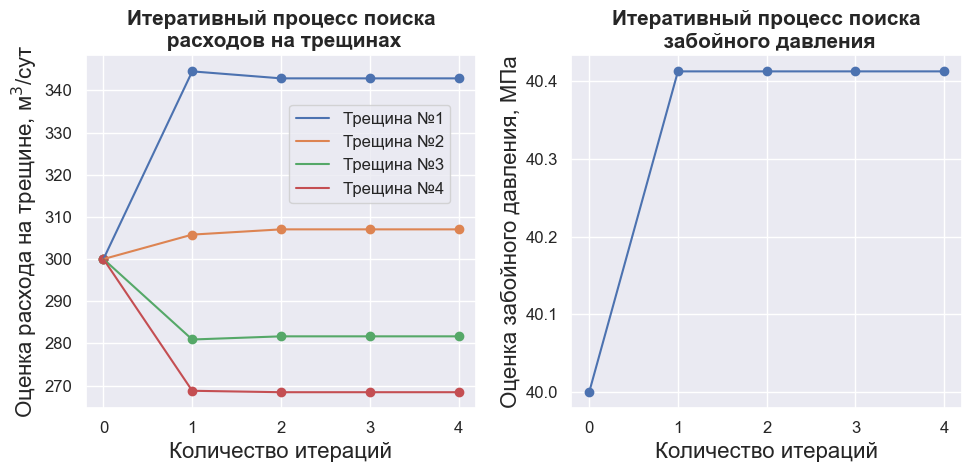

In [8]:
# построение графиков итерационного процесса решения
fig0, axs = plt.subplots(1, 2, figsize=(10,5))
for ii in range(fracs_count):
    axs[0].plot([i for i in range(len(iterative_history))],
                [item[ii]*86400 for item in iterative_history],
                label=f'Трещина №{ii+1}')
    axs[0].scatter([i for i in range(len(iterative_history))],
                   [item[ii]*86400 for item in iterative_history])
axs[0].set_title('Итеративный процесс поиска\n расходов на трещинах',
                 weight='bold', size=15)

axs[0].set_xlabel('Количество итераций')
axs[0].set_ylabel('Оценка расхода на трещине, м$^3$/сут')
axs[0].legend(bbox_to_anchor=(0.5, 0.72), ncol=1)

axs[1].plot([i for i in range(len(iterative_history))],
            [item[fracs_count]/1e6 for item in iterative_history])

axs[1].scatter([i for i in range(len(iterative_history))],
               [item[fracs_count]/1e6 for item in iterative_history])
axs[1].set_title('Итеративный процесс поиска\n забойного давления',
                 weight='bold',
                 size=15)
axs[1].set_xlabel('Количество итераций')
axs[1].set_ylabel('Оценка забойного давления, МПа')
fig0.tight_layout()
#fig0.savefig('myimage.jpg', dpi=300)

In [9]:
# формула Кёнинга
def koning_formula(leak_off_type='Carter'):
    if leak_off_type == 'Carter':
        kappa = k_e / (phi_e * K * c_t)
        x_frac = Q * K * ((S.Pi * kappa * t)**(1/2)) / \
            (2 * S.Pi * k_e * h * (p_frac_net + sigma_min - p_e))
    else:
        e_num = 2.718281828459045235
        kappa = k_e / (phi_e * K * c_t)
        under_exp = -2 * S.Pi * k_e * h * \
            (p_frac_net + sigma_min - p_e) / (Q * K)
        x_frac = 3 * (e_num)**(under_exp) * (kappa * t)**(1/2)
    return x_frac

Text(0.5, 1.0, 'Количество шагов по времени: 97')

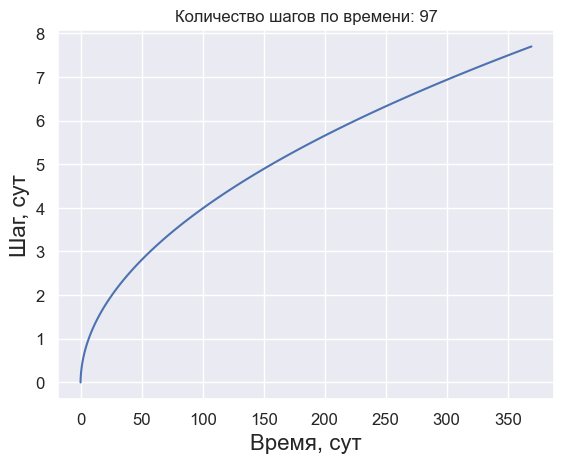

In [10]:
time_mesh = np.concatenate([np.array([0.1]), np.arange(1, 670000, 7000)])
for i, val in enumerate(time_mesh[1:]):
    time_mesh[i+1] += time_mesh[i]
plt.plot(time_mesh[1:] / 86400, (time_mesh[1:]-time_mesh[:-1]) / 86400)
plt.xlabel('Время, сут')
plt.ylabel('Шаг, сут')
plt.title(f'Количество шагов по времени: {len(time_mesh)}')

In [11]:
leak_off_regime = 'Carter'

q_start = 1200 / 86400 #0.02
q_end = 600 / 86400 #0.005

display_output = False

for_koning_values = {}

for_koning_values[t] = time_mesh[0]
for_koning_values[dt] = time_mesh[1] - time_mesh[0]

# список забойных давлений
p_0_values = []
# список чистых давлений в трещинах
p_net_values = []
# список дебитов на трещинах
Q_values = []
# список полудлин трещин
x_frac_values = [] # через приращение
x_frac_values_via_formula = [] # просто по формуле
# список минимальных чистых давлений в трещине для её распространения
p_net_prop_values = []

times_calc = time_mesh[:-1:5]

for t_ind, t_value in enumerate(tqdm(times_calc)):
    parameter_values[Q_0] = q_start + (q_end-q_start) * \
        (t_value-times_calc[0])/(times_calc[-1]-times_calc[0])
    #if t_value >= 70 * 86400:
    #parameter_values[C_d[1]] = 0.6
    #parameter_values[d_p[1]] = 0.01
    #if t_value >= 140 * 86400:
    #parameter_values[C_d[2]] = 0.7
    #parameter_values[d_p[2]] = 0.01
    #if t_value >= 210 * 86400:
    # parameter_values[C_d[3]] = 0.8
    if t_value > time_mesh[0]:
        solution_values_last = solution_values.copy()
    
    for_koning_values[t] = times_calc[t_ind]

    solution_values, _ = kirchhoff_solver(parameter_values)

    p_0_value = solution_values.get(p_0)
    p_0_values.append(p_0_value)

    Q_value = [solution_values[symbols('Q'+str(i), real=True)]
               for i in range(1, fracs_count+1)]
    Q_values.append(Q_value)

    p_net_value = [N(i.subs({**parameter_values, **solution_values}))
                   for i in p_net_with_leak_off()]
    p_net_values.append(p_net_value)

    for i in range(fracs_count):
        for_koning_values[p_frac_net[i]] = p_net_value[i]
    
    x_frac_values_via_formula.append(np.array(
        [N(i.subs({**parameter_values,
                   **solution_values,
                   **for_koning_values})
                   ) for i in koning_formula(leak_off_type=leak_off_regime)]))

    for i in range(fracs_count):
        parameter_values[x_f[i]] = x_frac_values_via_formula[-1][i]

    #if for_koning_values[t] >= 100:
    # parameter_values[d_p[1]] = 0.005
    if display_output:
        print(x_frac_values_via_formula[-1], 'метров')
        print(for_koning_values[t], ' сек')

100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


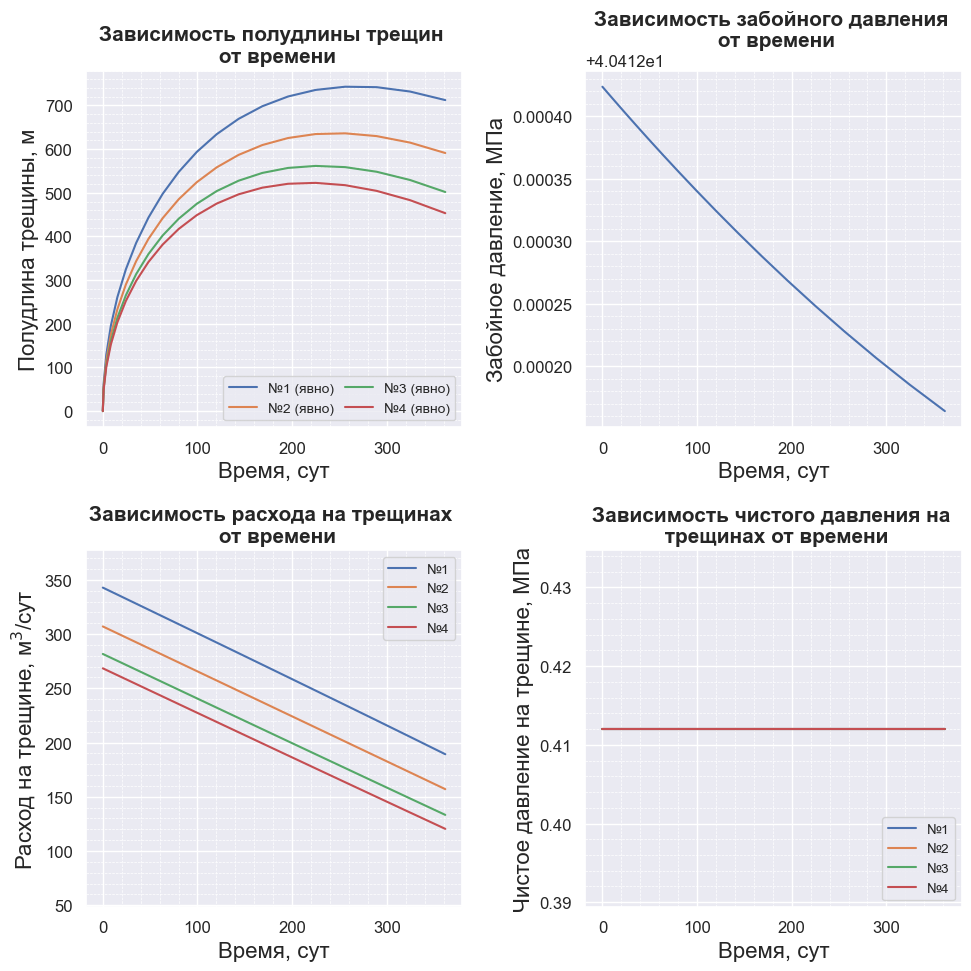

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

plt.rc('legend', fontsize=10)

axs[0,0].plot(times_calc / 86400, x_frac_values_via_formula,
              label=[f'№{i+1} (явно)' for i in range(fracs_count)])
axs[0,0].set_xlabel('Время, сут')
axs[0,0].set_ylabel('Полудлина трещины, м')
axs[0,0].set_title('Зависимость полудлины трещин \n от времени',
                   weight='bold',size=15)
axs[0,0].legend(ncol=2, columnspacing=0.8)
axs[0,0].minorticks_on()
axs[0,0].grid(which='minor', linestyle='--', linewidth=0.5)

axs[0,1].plot(times_calc/86400, np.array(p_0_values)/1e6)
axs[0,1].set_xlabel('Время, сут')
axs[0,1].set_ylabel('Забойное давление, МПа')
axs[0,1].set_title('Зависимость забойного давления \n от времени',
                   weight='bold',size=15)
axs[0,1].minorticks_on()
axs[0,1].grid(which='minor', linestyle='--', linewidth=0.5)

axs[1,0].plot(times_calc/86400, np.array(Q_values)*86400,
              label=[f'№{i+1}' for i in range(fracs_count)])
axs[1,0].set_ylim([0.4*min(np.array(Q_values).flatten())*86400,
                   1.1*max(np.array(Q_values).flatten())*86400])
axs[1,0].set_xlabel('Время, сут')
axs[1,0].set_ylabel('Расход на трещине, м$^3$/сут')
axs[1,0].set_title('Зависимость расхода на трещинах \n от времени',
                   weight='bold',size=15)
axs[1,0].legend()
axs[1,0].minorticks_on()
axs[1,0].grid(which='minor', linestyle='--', linewidth=0.5)


axs[1,1].plot(times_calc/86400, np.array(p_net_values)/1e6,
              label=[f'№{i+1}' for i in range(fracs_count)])
axs[1,1].set_xlabel('Время, сут')
axs[1,1].set_ylabel('Чистое давление на трещине, МПа')
axs[1,1].set_title('Зависимость чистого давления на \n трещинах от времени',
                   weight='bold',size=15)
axs[1,1].legend(loc="lower right")
axs[1,1].minorticks_on()
axs[1,1].grid(which='minor', linestyle='--', linewidth=0.5)

fig.tight_layout()